## Pipeline until TFIDF

In [1]:
import os
import pickle
from pprint import pprint
from os.path import join as JP

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

from utils.nlp_utils import preproces
from utils.general import parse_yaml, ensure_directories

from scripts.catalog import (
    Catalog, Document, Corpus,
    load_catalog, load_corpus)

config = parse_yaml('config.yaml')
paths = config['paths']
ensure_directories(paths)

catalog = Catalog()

## Load Catalog

catalog = load_catalog(path=paths['catalog'], name='spacy_pipeline_on_US_corpus')
# catalog.documents[0].sp_doc

print('Total documents = ', len(catalog.documents))

## TFIDF

### Collect the Corpus for Sklearn

corpus = catalog.collect_corpus(attr='processed_text', form=list)
document = corpus[0]
document[:500]

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from scripts.algorithms.clustering import (
    kmean_clustering,
    compute_word_importance,
    plot_clusters_as_wordclouds)

# TODO: Increase all these
EMBED_SIZE = 10000        
NUM_CLUSTERS = 4
WORDS_PER_CLUSTER = 50

vectorizer = TfidfVectorizer(
    min_df=.1,
    max_df=.7,
    norm='l2',
    use_idf=True,
    smooth_idf=True,
    max_features=EMBED_SIZE,
    ngram_range=(1,3),
    lowercase=True,
    stop_words=stopwords.words('english'))

tfidf = catalog.to_matrix(
    vectorizer=vectorizer,
    modelname='TFIDF',
    max_docs=None)
print(tfidf.representation.shape)
tfidf.representation.head()

15
(15, 9936)


,0000,0000 process,0000 process produce,0011,0015,0018,0021,0023,0028,0031,...,yield loss,yield low,yield method,yield mol,yield reaction,zeolite,zeolite diatomaceous,zeolite diatomaceous earth,zinc,zirconium
0,0.000000,0.000000,0.000000,0.0,0.005967,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.005967,0.004827,0.000000,0.000000,0.000000,0.004420,0.000000
1,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.003749,0.003749,0.000000,0.003749,...,0.000000,0.000000,0.0,0.000000,0.000000,0.003033,0.000000,0.000000,0.000000,0.000000
2,0.001422,0.000474,0.000474,0.0,0.000000,0.000474,0.000474,0.000474,0.000474,0.000000,...,0.000474,0.000474,0.0,0.000000,0.000767,0.000384,0.000474,0.000474,0.000351,0.000474
3,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.007083,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Hierarchical Clustering

### Similarity Matrix

In [41]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import dendrogram, linkage
simmilarity_matrix = cosine_similarity(tfidf.representation, tfidf.representation)

In [42]:
def check_symmetric(a, tol=1e-8):
    return np.all(np.abs(a-a.T) < tol)

check_symmetric(simmilarity_matrix)

True

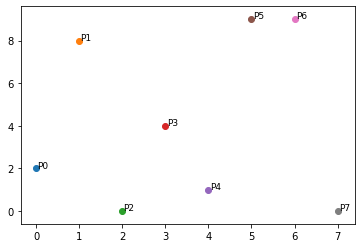

In [82]:
x1 = np.array(list(range(8)))
x2 = np.array([2, 8, 0, 4, 1, 9, 9, 0])
X = np.vstack((x1,x2)).T

labels = ['P{}'.format(i) for i in x1]

for i,(x1i,x2i) in enumerate(zip(x1,x2)):
    plt.scatter(x1i, x2i)
    plt.text(x1i+.03, x2i+.03, labels[i], fontsize=9)
plt.show()

In [89]:
model = AgglomerativeClustering(linkage='average', compute_full_tree=True)

In [102]:
model.fit(X)
model.children_

array([[ 5,  6],
       [ 2,  4],
       [ 0,  9],
       [ 3, 10],
       [ 1,  8],
       [ 7, 11],
       [12, 13]])

array([[ 5.,  6.,  0.,  2.],
       [ 2.,  4.,  1.,  3.],
       [ 0.,  9.,  2.,  4.],
       [ 3., 10.,  3.,  5.],
       [ 1.,  8.,  4.,  6.],
       [ 7., 11.,  5.,  7.],
       [12., 13.,  6.,  8.]])

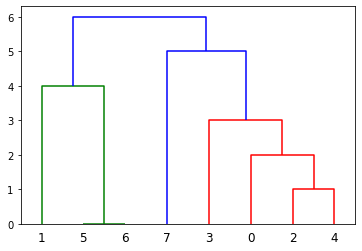

In [129]:
children = model.children_
distance = np.arange(children.shape[0])
no_of_observations = np.arange(2, children.shape[0]+2)
linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)
dendrogram(linkage_matrix)
linkage_matrix

In [130]:
Z = linkage(X, 'average')

In [131]:
Z

array([[ 5.        ,  6.        ,  1.        ,  2.        ],
       [ 2.        ,  4.        ,  2.23606798,  2.        ],
       [ 0.        ,  9.        ,  3.47576638,  3.        ],
       [ 3.        , 10.        ,  3.63031152,  4.        ],
       [ 1.        ,  8.        ,  4.61106257,  3.        ],
       [ 7.        , 11.        ,  5.27481045,  5.        ],
       [12.        , 13.        ,  7.94600034,  8.        ]])

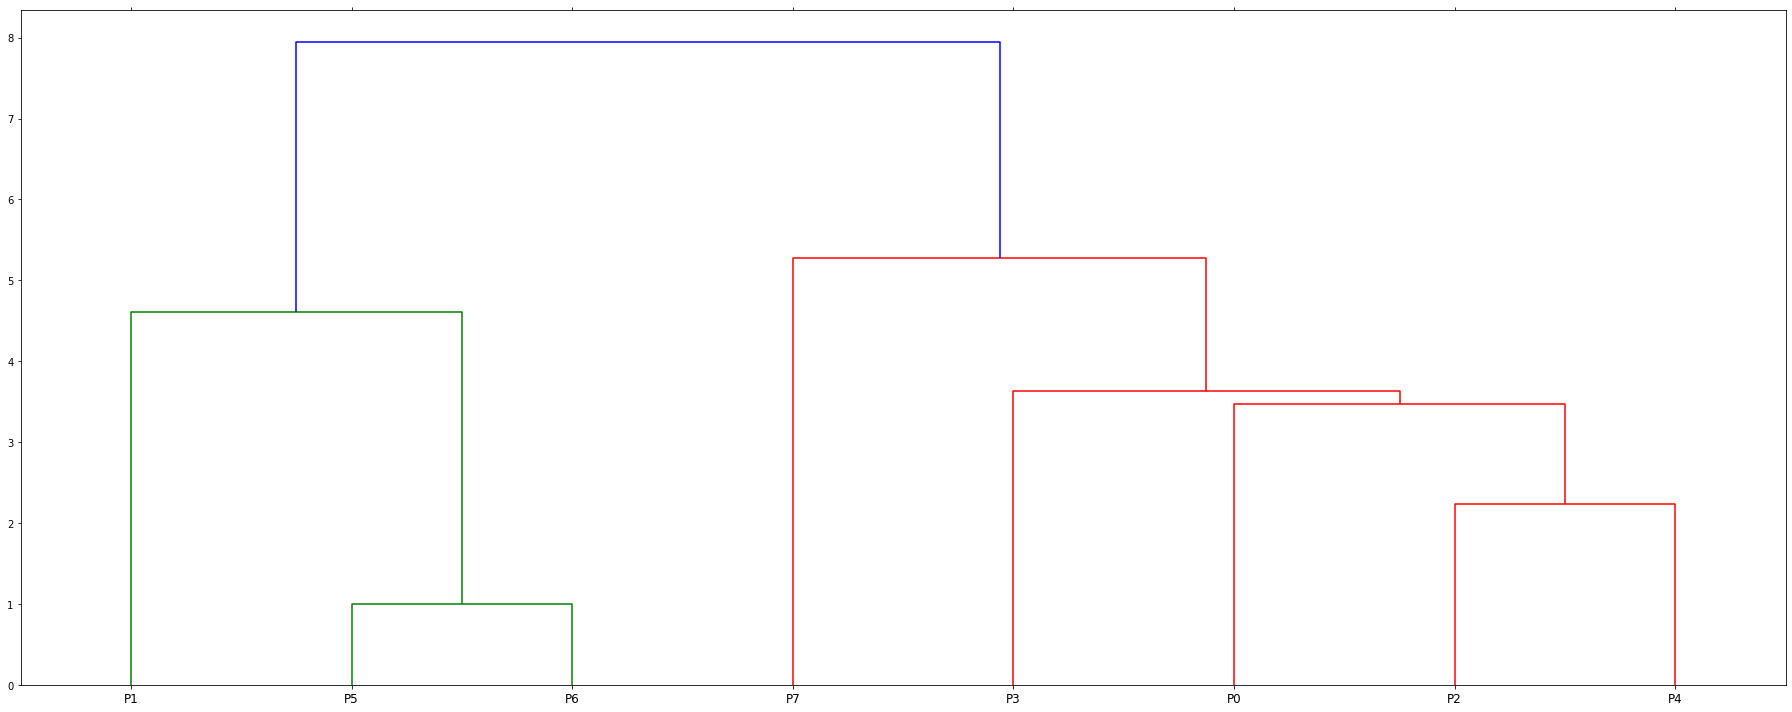

In [115]:
fig = plt.figure(figsize=(25, 10))
ax = dendrogram(
    Z,
    orientation='top',
    labels=labels)

plt.tick_params(
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout
plt.show()

In [132]:
from scipy.spatial.distance import pdist, squareform

In [133]:
d = pdist(X, metric='euclidean')
D = squareform(d)

In [139]:
print(d.shape)
d

(28,)


array([ 6.08276253,  2.82842712,  3.60555128,  4.12310563,  8.60232527,
        9.21954446,  7.28010989,  8.06225775,  4.47213595,  7.61577311,
        4.12310563,  5.09901951, 10.        ,  4.12310563,  2.23606798,
        9.48683298,  9.8488578 ,  5.        ,  3.16227766,  5.38516481,
        5.83095189,  5.65685425,  8.06225775,  8.24621125,  3.16227766,
        1.        ,  9.21954446,  9.05538514])

In [140]:
print(D.shape)
D

(8, 8)


array([[ 0.        ,  6.08276253,  2.82842712,  3.60555128,  4.12310563,
         8.60232527,  9.21954446,  7.28010989],
       [ 6.08276253,  0.        ,  8.06225775,  4.47213595,  7.61577311,
         4.12310563,  5.09901951, 10.        ],
       [ 2.82842712,  8.06225775,  0.        ,  4.12310563,  2.23606798,
         9.48683298,  9.8488578 ,  5.        ],
       [ 3.60555128,  4.47213595,  4.12310563,  0.        ,  3.16227766,
         5.38516481,  5.83095189,  5.65685425],
       [ 4.12310563,  7.61577311,  2.23606798,  3.16227766,  0.        ,
         8.06225775,  8.24621125,  3.16227766],
       [ 8.60232527,  4.12310563,  9.48683298,  5.38516481,  8.06225775,
         0.        ,  1.        ,  9.21954446],
       [ 9.21954446,  5.09901951,  9.8488578 ,  5.83095189,  8.24621125,
         1.        ,  0.        ,  9.05538514],
       [ 7.28010989, 10.        ,  5.        ,  5.65685425,  3.16227766,
         9.21954446,  9.05538514,  0.        ]])

In [123]:
D = pdist(X, metric='cosine')

In [124]:
D

array([0.00772212, 1.        , 0.2       , 0.75746437, 0.12584272,
       0.16794971, 1.        , 0.87596527, 0.13175686, 0.6390059 ,
       0.07235648, 0.10557281, 0.87596527, 0.4       , 0.0298575 ,
       0.51435707, 0.4452998 , 0.        , 0.223886  , 0.00928842,
       0.00153965, 0.4       , 0.31684287, 0.26005993, 0.0298575 ,
       0.00327095, 0.51435707, 0.4452998 ])

In [125]:
D.shape

(28,)

In [143]:
d_ = cosine_similarity(X,X)
print(d_.shape)
d_

(8, 8)


array([[1.        , 0.99227788, 0.        , 0.8       , 0.24253563,
        0.87415728, 0.83205029, 0.        ],
       [0.99227788, 1.        , 0.12403473, 0.86824314, 0.3609941 ,
        0.92764352, 0.89442719, 0.12403473],
       [0.        , 0.12403473, 1.        , 0.6       , 0.9701425 ,
        0.48564293, 0.5547002 , 1.        ],
       [0.8       , 0.86824314, 0.6       , 1.        , 0.776114  ,
        0.99071158, 0.99846035, 0.6       ],
       [0.24253563, 0.3609941 , 0.9701425 , 0.776114  , 1.        ,
        0.68315713, 0.73994007, 0.9701425 ],
       [0.87415728, 0.92764352, 0.48564293, 0.99071158, 0.68315713,
        1.        , 0.99672905, 0.48564293],
       [0.83205029, 0.89442719, 0.5547002 , 0.99846035, 0.73994007,
        0.99672905, 1.        , 0.5547002 ],
       [0.        , 0.12403473, 1.        , 0.6       , 0.9701425 ,
        0.48564293, 0.5547002 , 1.        ]])